# HOUSE ROCKET

## PROJETO DE INSIGHTS

* Objetivo: Gerar insights através da análise e manipulação dos dados para auxiliar na tomada de decisão (Compra e venda) pelo time de negócio.

### Questão de Negócio

Vamos responder as seguintes questões:

1. Quais são os imóveis que a House Rocket deveria comprar e por qual preço ?
2. Uma vez a casa comprada, qual o melhor momento para vendê-las e por qual preço ?

Partirei da premissa de comprar casas com valor menor que a mediana de cada região.

## 0.0 - Library

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import time
import csv

from multiprocessing import Pool

from matplotlib import gridspec
from IPython.core.display import HTML

pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 0.1 - Data

In [2]:
data = pd.read_csv('datasets/kc_house_data.csv')

In [3]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.00,3,1.00,1180,5650,1.00,0,0,...,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,20141209T000000,538000.00,3,2.25,2570,7242,2.00,0,0,...,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,20150225T000000,180000.00,2,1.00,770,10000,1.00,0,0,...,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,2487200875,20141209T000000,604000.00,4,3.00,1960,5000,1.00,0,0,...,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,20150218T000000,510000.00,3,2.00,1680,8080,1.00,0,0,...,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503


### 0.3 - FUNCTIONS

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [20,12]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container{width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set()
    
jupyter_settings()

def selecionar(data):
    
    for i in data.index:
        if ((data.loc[i, 'price'] < data.loc[i, 'price_median']) & (data.loc[i, 'condition'] >= 3)):
            data.loc[i,'status'] = 'BUY'
        else:
            data.loc[i,'status'] = 'DO NOT BUY'
        
    return None

def hipo2(data):
    data['ano'] = data['yr_built'].apply(lambda x: '> 1955' if x < 1955 else '< 1955')
    
    h2 = data[['ano','price']].groupby('ano').mean().reset_index()

    return h2

def hipo3(data):
    data['porao'] = data['sqft_basement'].apply(lambda x: 'nao' if x == 0 else 'sim')
    h3 = data[['porao', 'sqft_lot', 'price']].groupby('porao').mean().reset_index()
    x3 = ((h3.iloc[0,1]-h3.iloc[1,1])/h3.iloc[1,1])*100
    return x3

def hipo4(data):
    data['reforma'] = data['yr_renovated'].apply(lambda x: 'nao' if x == 0 else 'sim')
    h4 = data[['price', 'reforma']].groupby('reforma').mean().reset_index()
    x4 = ((h4.iloc[0,1]-h4.iloc[1,1])/h4.iloc[1,1])*100
    return x4

def hipo5(data):
    data['banheiro'] = data['bathrooms'].apply(lambda x: '0-3' if (x > 0) & (x < 3) else
                                         '3-5' if (x > 3) & (x < 5) else '5-8')
    h5 = data[['banheiro', 'price']].groupby('banheiro').mean().reset_index()
    x5 = ((h5.iloc[1,1]-h5.iloc[0,1])/h5.iloc[0,1])*100
    x51 = ((h5.iloc[2,1]-h5.iloc[0,1])/h5.iloc[0,1])*100
    
    return x5, x51

def hipo6(data):
    data['quartos'] = data['bedrooms'].apply(lambda x: '0-3' if (x > 0) & (x <= 3) else
                                      '3-5' if (x > 3) & (x <= 5) else 
                                      '5-8' if (x > 5) & (x <= 8) else '8-11' ) 
    h6 = data[['quartos', 'price']].groupby('quartos').mean().reset_index()
    
    return h6

Populating the interactive namespace from numpy and matplotlib


## 1.0 - LIMPEZA E TRANSFORMAÇÃO DOS DADOS

Primeiro irei agrupar os dados por região (Zipcode) e tirar a mediana de preços por região, dessa maneira, a comparação de preços será mais acertada.

In [5]:
df = data[['zipcode', 'price']].groupby('zipcode').median().reset_index()

In [6]:
df2 = pd.merge(data, df, on='zipcode', how='inner')

In [7]:
df2.columns = ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price_median']

In [8]:
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d')

In [9]:
df2.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_median
count,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00
mean,4580301520.86,540088.14,3.37,2.11,2079.90,15106.97,1.49,0.01,0.23,3.41,7.66,1788.39,291.51,1971.01,84.40,98077.94,47.56,-122.21,1986.55,12768.46,485863.94
std,2876565571.31,367127.20,0.93,0.77,918.44,41420.51,0.54,0.09,0.77,0.65,1.18,828.09,442.58,29.37,401.68,53.51,0.14,0.14,685.39,27304.18,196658.61
min,1000102.00,75000.00,0.00,0.00,290.00,520.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00,235000.00
25%,2123049194.00,321950.00,3.00,1.75,1427.00,5040.00,1.00,0.00,0.00,3.00,7.00,1190.00,0.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00,335000.00
50%,3904930410.00,450000.00,3.00,2.25,1910.00,7618.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00,445950.00
75%,7308900445.00,645000.00,4.00,2.50,2550.00,10688.00,2.00,0.00,0.00,4.00,8.00,2210.00,560.00,1997.00,0.00,98118.00,47.68,-122.12,2360.00,10083.00,572000.00
max,9900000190.00,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,4820.00,2015.00,2015.00,98199.00,47.78,-121.31,6210.00,871200.00,1892500.00


Já percebi um possível outlier de 33 quartos, pois ele está bem longe da mediana, e da média também, verifiquei que há somente um dado com essa característica, portanto achei mais eficiente tira-lá da análise

In [10]:
df2 = df2.loc[df2['bedrooms'] != 33]

Agora eu vou criar uma coluna chamada status, onde colocarei a sugestão de compra ou não, conforme a premissa de que se o preço do imovel for menor que a mediana da região, o status e de compra, caso não, de não compra.

In [11]:
df2['status'] = 'STATUS'

In [12]:
df3 = df2.copy()

In [13]:
selecionar(df3)

In [14]:
df3 = df3[df3['status'] == 'BUY']

In [15]:
df3['status'].value_counts()

BUY    10579
Name: status, dtype: int64

Existem 10579 imóvies com potencial de ganho, agora iremos refinar para tentarmos maximizar os imóveis com maiores potenciais de ganho

## 2.0 - Exploração dos Dados (EDA)

### H1: Imóveis que possuem vista para água, são 30% mais caros, na média.  (V)


Os imóvei na média estão mais caros que 30%, e os imóveis com possibilidade de compra estão mais baratos na media do que as casas sem vista, portanto um ótimo negócio.

In [16]:
df2[['waterfront', 'price']].groupby('waterfront').mean().reset_index()

,waterfront,price
0,0,531558.54
1,1,1661876.02


In [17]:
df3[['waterfront', 'price']].groupby('waterfront').mean().reset_index()

,waterfront,price
0,0,387038.08
1,1,357721.33


### H2: Imóveis com data de construção menor que 1955, são 50% mais baratos, na média. (F)

In [18]:
hipo2(df2)

,ano,price
0,< 1955,541299.97
1,> 1955,537034.20


### H3 - Imóveis sem porão são 40% maiores do que imóveis com porão (F)

Os imóveis em média são 22,55% maiores.

In [19]:
hipo3(df2)

22.555796220754452

### H4 - Imóveis que nunca foram reformados são em média 30% mais barato (V)

Os Imóveis sem reforma estão em média 30,25% mais baratos que os reformados

In [20]:
hipo4(df2)

-30.25116416146483

### H5 - Imóveis com mais banheiros são em média 15% mais caros (F)

Os imóveis com 3-5 banheiros são 120% mais caros que os de 0-3 banheiros, e os de 5-8 banheiros são 72% mais caros que os de 0-3.

In [21]:
hipo5(df2)

(120.27236258866452, 72.31056145526189)

### H6 - Imóveis com mais quartos são em média 15% mais caros (F)

Os imóveis mais caros são as com 5 a 8 quartos, e são em média 43% mais caros que as com 8 a 11 quartos.

In [42]:
hh = hipo6(df2)

In [43]:
hh

,quartos,price
0,0-3,449915.00
1,3-5,663951.83
2,5-8,851556.13
3,8-11,594154.30


In [47]:
x6 = ((hh.iloc[2,1]-hh.iloc[3,1])/hh.iloc[3,1])*100

x61 = ((hh.iloc[2,1]-hh.iloc[0,1])/hh.iloc[0,1])*100

x61

89.27044565952107

### H7 - O crescimento do preço dos imóveis mês após mês no ano de 2014 é de 10% (F)


Podemos ver graficamente que há quedas em alguns meses

In [24]:
df2['year'] = df2['date'].dt.year
df2['month'] = df2['date'].dt.month

In [25]:
x = df2[df2['year']==2014]

<AxesSubplot:xlabel='month', ylabel='price'>

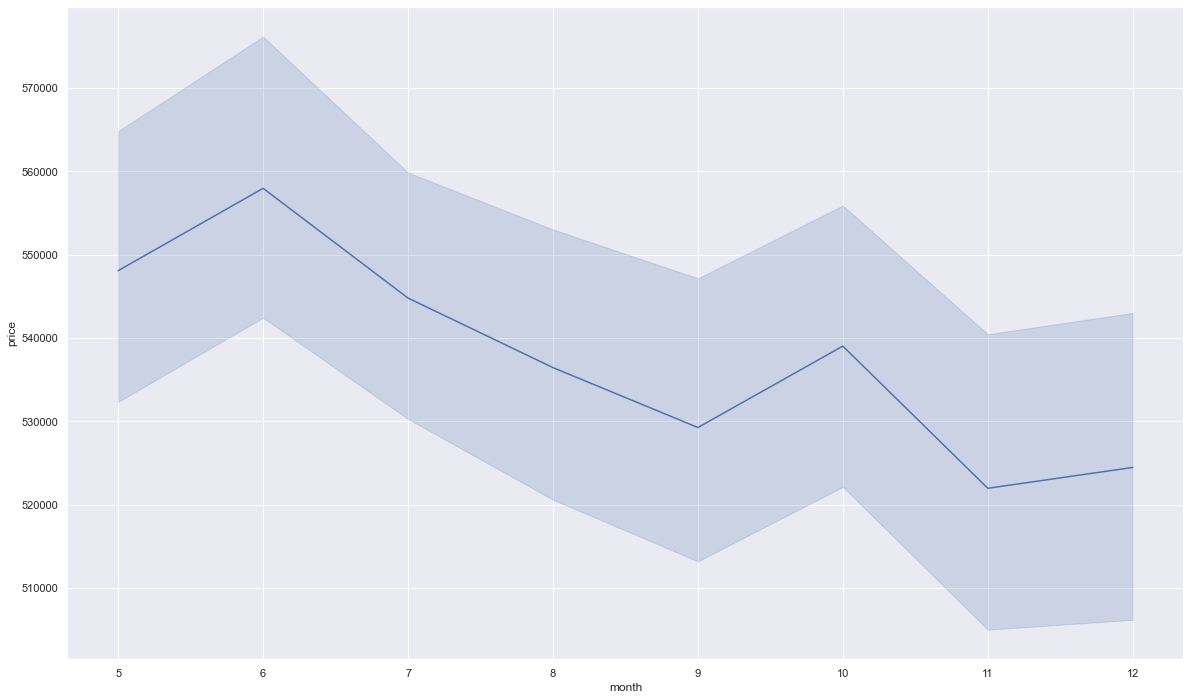

In [26]:
sns.lineplot(data=x, x='month', y='price')

### H8 - O crescimento do preço dos imóveis ano após ano é de 10% (F)

<AxesSubplot:xlabel='year', ylabel='price'>

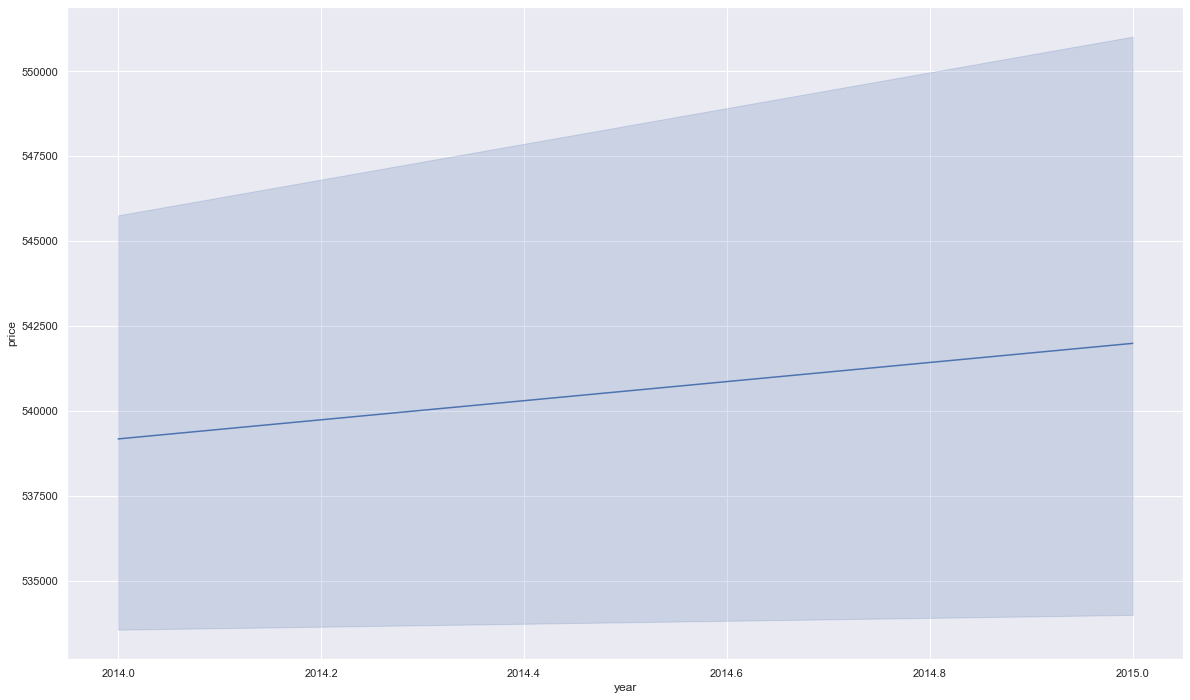

In [27]:
yoy = df2[['year','price']]

sns.lineplot(data=yoy, x='year', y='price')

In [28]:
h8 = yoy.groupby('year').mean().reset_index()
h8

,year,price
0,2014,539174.54
1,2015,541988.99


In [29]:
x8 = ((h8.iloc[1,1]-h8.iloc[0,1])/h8.iloc[0,1])*100
x8

0.5219931448820375

In [30]:
df4 = df3.copy()

In [31]:
df4['diference'] = df4['price_median'] - df4['price']

In [32]:
df4.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_median,status,diference
0,7129300520,2014-10-13,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650,278277.00,BUY,56377.00
1,4060000240,2014-06-23,205425.00,2,1.00,880,6780,1.00,0,0,4,6,880,0,1945,0,98178,47.50,-122.25,1190,6780,278277.00,BUY,72852.00
3,2976800796,2014-09-25,236000.00,3,1.00,1300,5898,1.00,0,0,3,7,1300,0,1961,0,98178,47.51,-122.25,1320,7619,278277.00,BUY,42277.00
4,6874200960,2015-02-27,170000.00,2,1.00,860,5265,1.00,0,0,3,6,860,0,1931,0,98178,47.50,-122.27,1650,8775,278277.00,BUY,108277.00
5,4268200055,2015-05-01,245000.00,3,1.75,1740,11547,1.00,0,0,3,7,1740,0,1954,0,98178,47.49,-122.22,880,78408,278277.00,BUY,33277.00


In [33]:
conclusion = df4[['id', 'zipcode', 'waterfront', 'price', 'diference', 'price_median']]

In [34]:
table = conclusion.sort_values('diference', ascending = False).reset_index().head(20)

In [35]:
table

,index,id,zipcode,waterfront,price,diference,price_median
0,21582,5425700150,98039,0,787500.00,1105000.00,1892500.00
1,21577,3262301610,98039,0,865000.00,1027500.00,1892500.00
2,21565,3262300940,98039,0,875000.00,1017500.00,1892500.00
3,21569,2210500019,98039,0,937500.00,955000.00,1892500.00
4,21566,3262300940,98039,0,940000.00,952500.00,1892500.00
5,21578,5426300060,98039,0,1000000.00,892500.00,1892500.00
6,7418,5016003230,98112,0,169317.00,745683.00,915000.00
7,21570,6447300345,98039,0,1160000.00,732500.00,1892500.00
8,21597,3262300920,98039,0,1200000.00,692500.00,1892500.00
9,21587,5427110040,98039,0,1225000.00,667500.00,1892500.00


In [36]:
table['zipcode'].value_counts()

98039    11
98112     4
98004     4
98033     1
Name: zipcode, dtype: int64

In [37]:
investimento = table['price'].sum()
investimento

15215317.0

In [38]:
lucro = table['diference'].sum()
lucro

14540533.0

In [39]:
pp = (lucro/investimento) *100

pp

95.56510061538646

In [40]:
df = pd.DataFrame(table)

In [41]:
 df.to_csv('table.csv', index=False)